In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import scienceplots
import shutup

from joblib import Parallel, delayed

from lib import data, spks_utils, fitlvm_utils, fit_models, eval_models, models, utils

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
# pretty plots
plt.style.use(['nature'])
plt.rcParams['figure.dpi'] = 200
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

# seed and suppress warnings :-)
fit_models.seed()
shutup.please()

In [ ]:
# # trial_data_r_all, trial_data_all, session_data_all, unit_spike_times_all, regions_all = data.load_data(thresh=1) # 1m 15s
# regions_all = np.array([[list(unit_spike_times_all[subj_idx][sess_idx].keys()) for sess_idx in range(len(data.session_ids[subj_idx]))] for subj_idx in range(len(data.subject_ids))])
# # trial_data_all_npz = utils.list2ndarr(trial_data_all)
# # np.savez("vars/trial_data_all_MM012_MM013_5sess.npz", trial_data_all_npz)
# # np.save("vars/session_data_all_MM012_MM013_5sess.npy", session_data_all)
# # np.save("vars/unit_spike_times_all_MM012_MM013_5sess.npy", unit_spike_times_all)
# np.save("vars/regions_all.npy", regions_all, allow_pickle=True)

In [3]:
trial_data_all = np.load("vars/trial_data_all_MM012_MM013_5sess.npz", allow_pickle=True)['arr_0']
session_data_all = np.load("vars/session_data_all_MM012_MM013_5sess.npy", allow_pickle=True)
unit_spike_times_all = np.load("vars/unit_spike_times_all_MM012_MM013_5sess.npy", allow_pickle=True)
regions_all = np.load("vars/regions_all.npy", allow_pickle=True)

## NB

In [4]:
subj_idx = 0; sess_idx = 3

unit_spike_times = unit_spike_times_all[subj_idx][sess_idx]
trial_data = trial_data_all[subj_idx][sess_idx]
session_data = session_data_all[subj_idx][sess_idx]
regions = regions_all[subj_idx][sess_idx]

In [5]:
psths, _, _, _, _, _, mask = data.get_psths(unit_spike_times, trial_data, session_data, regions, 
                                tpre=0.5, tpost=0.5, binwidth_ms=25, alignment='choice', 
                            balance=True, reward_only=False, do_rem_zstd=True, shuffle=False, prev_filter=False)
trial_data = trial_data[mask]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_gd, train_dl, val_dl, test_dl, train_inds, val_inds, test_inds, Mtrain, Mtest, sample, num_trials, num_tv, num_units = fitlvm_utils.get_data_model(psths, trial_data, regions, norm=False, num_tents=2, task_vars=['response', 'rewarded', 'response_prev', 'rewarded_prev'])

0 291 96 16
originally 186 units
good units 186
403 Trials, 186 Neurons


Step 0
Found 81 /186 units with stable low-dimensional structure at rank 1
Step 1: Baseline
Fitting baseline model...done
Step 2: Task Var
Fitting task variable model...done
Step 2a: Eval
as expected
as expected
Step3a: Inclusion Criteria
Found 163 /186 units with significant task variable + drift model
183 185
Using 175 total units for modeling


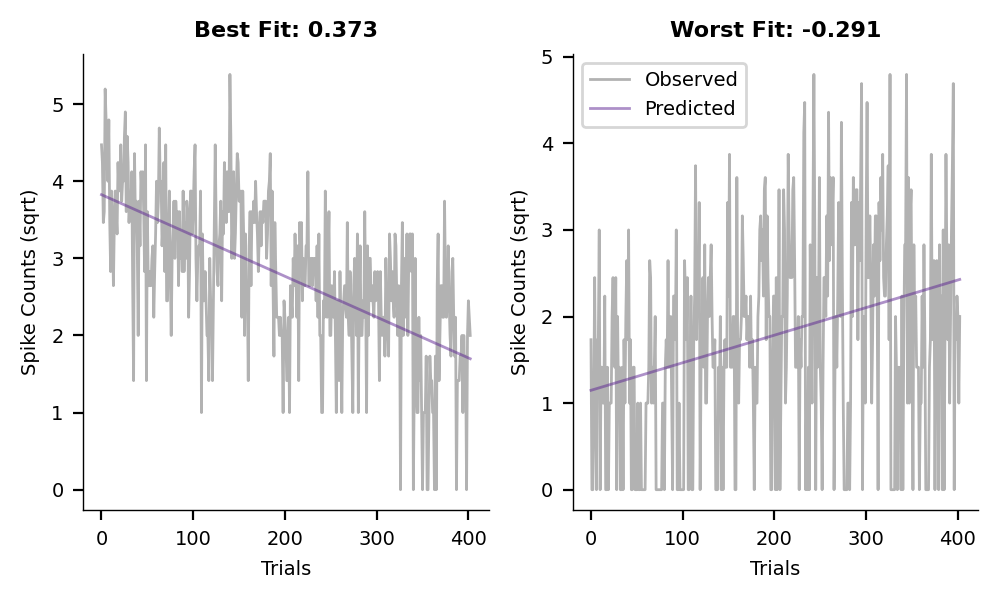

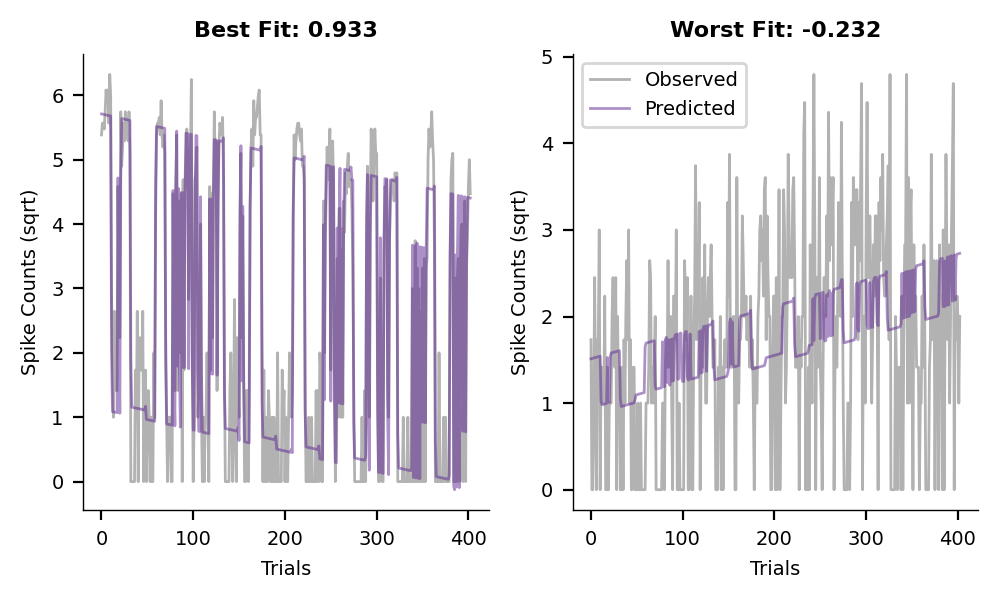

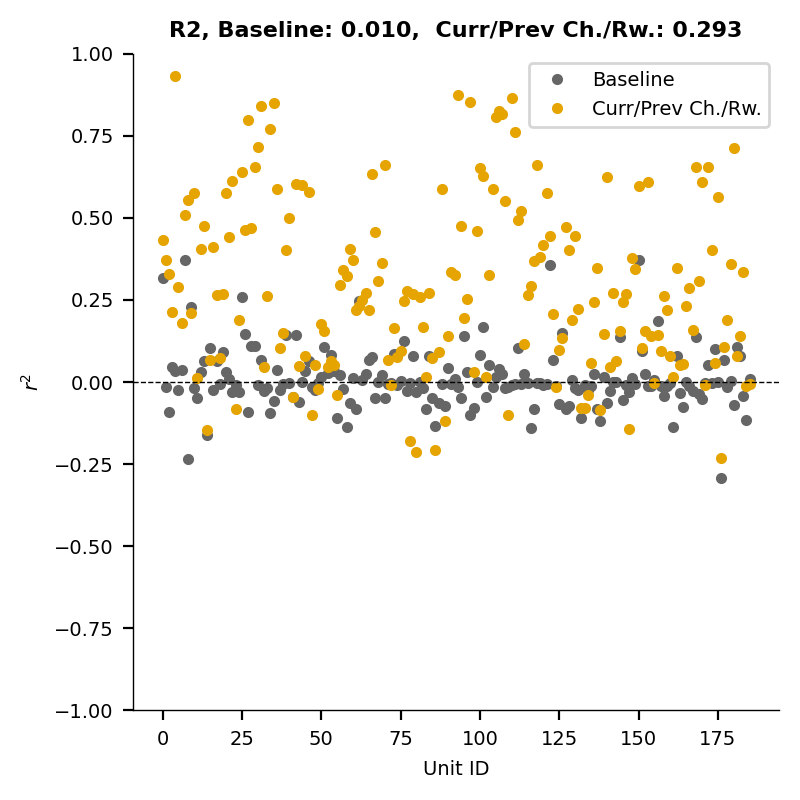

In [16]:
# MODELING
# Step 0: Check if dataset has stable low-dim structure at 4+ dims
print("Step 0")
cids_pca = fitlvm_utils.check_stable_lowd(data_gd, Mtrain, Mtest, num_units)

# Step 1: Fit baseline model
# > Baseline model: has no task vars, can capture slow drift in firing rate for each unit using b0-splines
print("Step 1: Baseline")
mod_baseline = fitlvm_utils.fit_baseline(train_dl, val_dl, num_tv, num_units, ntents=2)

# Step 2: Fit model with task vars and slow drift
# > Task vars & slow drift: Used to identify units driven by task vars
print("Step 2: Task Var")
mod_tv = fitlvm_utils.fit_tvs(train_dl, val_dl, num_tv, num_units, mod_baseline) 

# Step 2a: Evaluate and plot comparison for baseline and task variable models
print("Step 2a: Eval")
res_baseline        = fitlvm_utils.eval_model(mod_baseline, data_gd, test_dl.dataset, do_plot=True, save=False)
res_tv              = fitlvm_utils.eval_model(mod_tv, data_gd, test_dl.dataset, do_plot=True, save=False)
fitlvm_utils.plot_r2_comp([], res_baseline, res_tv, label_a="Baseline", label_b="Curr/Prev Ch./Rw.", save=False)

# Step 3a: Get units that had significant performance increase with a task variable model
print("Step3a: Inclusion Criteria")
cids = fitlvm_utils.get_cids(cids_pca, res_tv)

In [8]:
# Step 3b: Fit gain autoencoder
# NOTE: fitting done by first fixing drift/tv, first pass fit latent weights; then refit drift/tv and latents independently
print("Step 3b: Gain AE")
mod_ae_gain = fitlvm_utils.fit_ae_gain(train_dl, val_dl, mod_tv, cids, num_tv, num_units, data_gd, num_latents=3) 

# Step 3c: Fit offset autoencoder
print("Step 3c: Offset AE")
mod_ae_offset = fitlvm_utils.fit_ae_offset(train_dl, val_dl, mod_tv, cids, num_tv, num_units, data_gd, num_latents=3)

# Step 3d: Fit affine autoencoder
print("Step 3d: Affine AE")
mod_ae_affine, r2 = fitlvm_utils.fit_ae_affine(train_dl, val_dl, test_dl, mod_tv, mod_ae_gain, mod_ae_offset, cids, num_tv, num_units, data_gd, device, num_latents=3)


Step 3b: Gain AE
Fitting gain autoencoder...Initial: -6.5101
Fit latents: -6.5101, 0.3696
0) fit task vars: 0.3696, 0.3443
0) fit latents: 0.3443, 0.3574
1) fit task vars: 0.3574, 0.3557
breaking because tolerance was hit
Done
Step 3c: Offset AE
Fitting offset autoencoder...
Initial: -33.1990
Fit latents: -33.1990, 0.3816
0) fit task vars: 0.3816, 0.3584
0) fit latents: 0.3584, 0.3646
1) fit task vars: 0.3646, 0.3598
breaking because tolerance was hit
Done
Step 3d: Affine AE
Fitting affine autoencoder...Initial: -2.1645
Fit latents: -2.1645, 0.4036
0) fit task vars: 0.4036, 0.3897
0) fit latents: 0.3897, 0.3842
1) fit task vars: 0.3842, 0.3906
1) fit latents: 0.3906, 0.3929
2) fit task vars: 0.3929, 0.3961
2) fit latents: 0.3961, 0.3943
breaking because tolerance was hit
Done
Autoencoder iter 0, val r2: 0.3943
as expected
checkpoint 1
checkpoint 2
confirming model r2 = 0.4123


Step 2a: Eval
as expected
checkpoint 1
checkpoint 2
as expected


[<Figure size 800x800 with 1 Axes>]

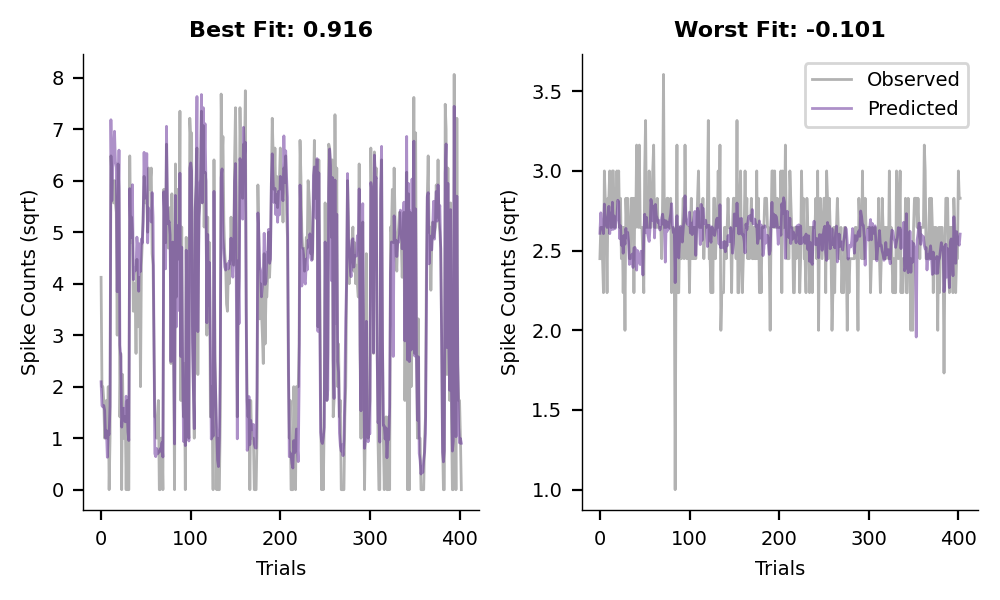

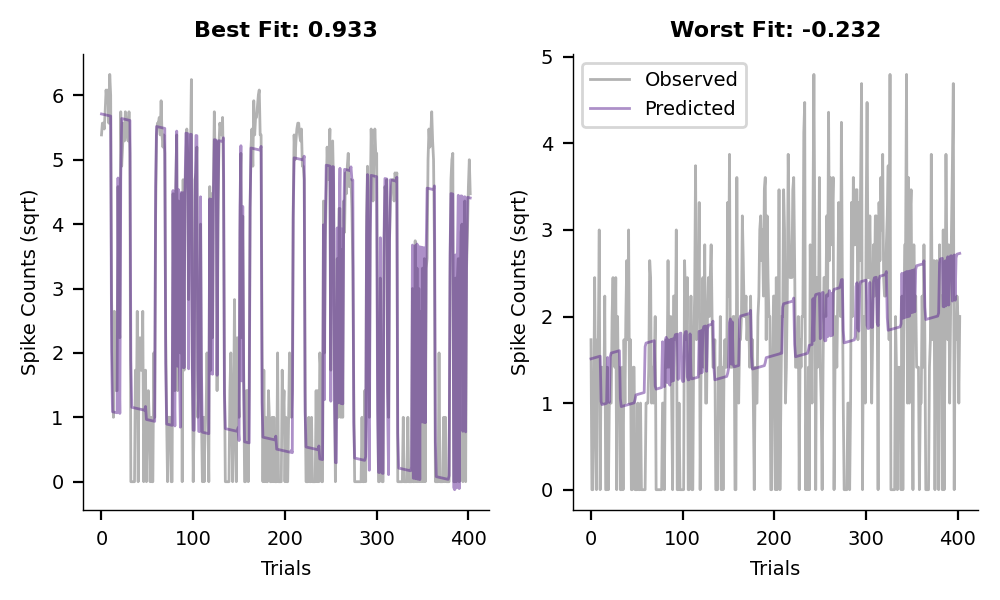

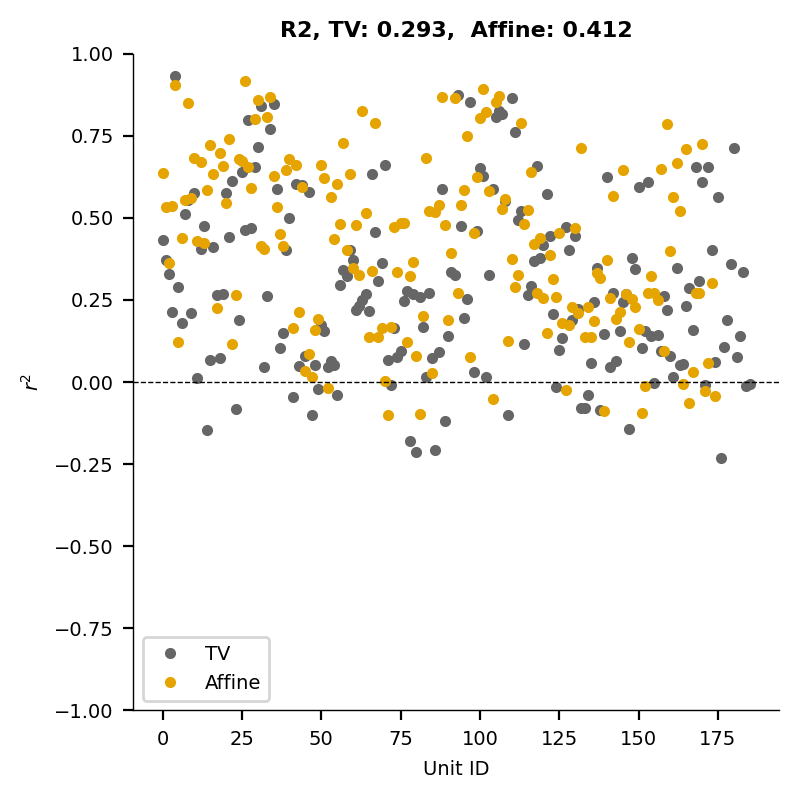

In [9]:
# Step 2a: Evaluate and plot comparison for baseline and task variable models
print("Step 2a: Eval")
res_affineae        = fitlvm_utils.eval_model(mod_ae_affine, data_gd, test_dl.dataset, do_plot=True, save=False)
res_tv              = fitlvm_utils.eval_model(mod_tv, data_gd, test_dl.dataset, do_plot=True, save=False)
fitlvm_utils.plot_r2_comp([], res_tv, res_affineae, label_a="TV", label_b="Affine", save=False)

In [10]:
# Step 3e: Convert ae to lvm
# NOTE: the difference between affine and affineae is that affineae (step 3) is fit with weights initialized by an autoencoder
print("Step 3e: AE to LVM")
mod_ae_offset, mod_ae_gain, mod_ae_affine_lvm = fitlvm_utils.ae2lvm(train_dl, val_dl, mod_ae_offset, mod_ae_gain, mod_ae_affine, cids, num_tv, num_units, data_gd, num_latents=3)

# Step 4: Fit affine model
print("Step 4: Fit Affine")
mod_affine = fitlvm_utils.fit_affine(train_dl, val_dl, mod_tv, cids, num_tv, num_units, data_gd, num_latents=3)


Step 3e: AE to LVM
Initial: 0.3598
Fit run 0.000,0.010: 0.3598
Initial: 0.3557
Fit run 0.010,0.000: 0.3557
Initial: 0.3943
Fit run 0.010,0.010: 0.3943
Step 4: Fit Affine
Fitting Affine Model...Initial: 0.3025
Initial: 0.3025
Fit latents: 0.3025, 0.3546
0) fit stim: 0.3025, 0.3511
0) fit latents: 0.3511, 0.3560
1) fit stim: 0.3560, 0.3559
breaking because tolerance was hit
Fit run 0.000,0.000: 0.3560, train loss = 0.5314
Initial: 0.3025
Initial: 0.3025
Fit latents: 0.3025, 0.3588
0) fit stim: 0.3025, 0.3539
0) fit latents: 0.3539, 0.3585
1) fit stim: 0.3585, 0.3579
breaking because tolerance was hit
Fit run 0.000,0.000: 0.3585, train loss = 0.5318
Initial: 0.3025
Initial: 0.3025
Fit latents: 0.3025, 0.3708
0) fit stim: 0.3025, 0.3576
0) fit latents: 0.3576, 0.3637
1) fit stim: 0.3637, 0.3615
breaking because tolerance was hit
Fit run 0.000,0.000: 0.3637, train loss = 0.5366
Initial: 0.3025
Initial: 0.3025
Fit latents: 0.3025, 0.3741
0) fit stim: 0.3025, 0.3492
0) fit latents: 0.3492, 0.

Step 2a: Eval
as expected
checkpoint 1
checkpoint 2


[<Figure size 800x800 with 1 Axes>]

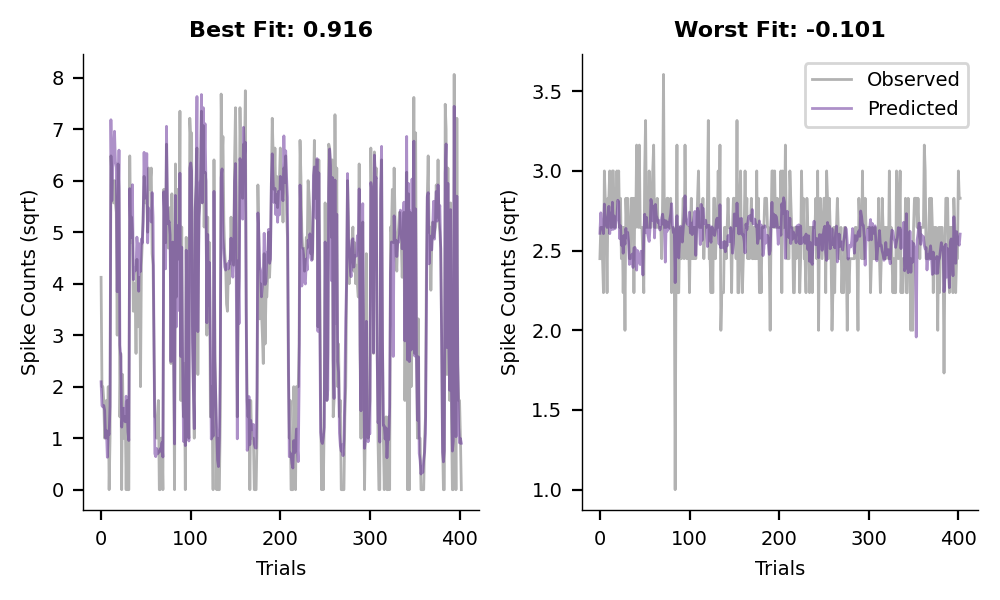

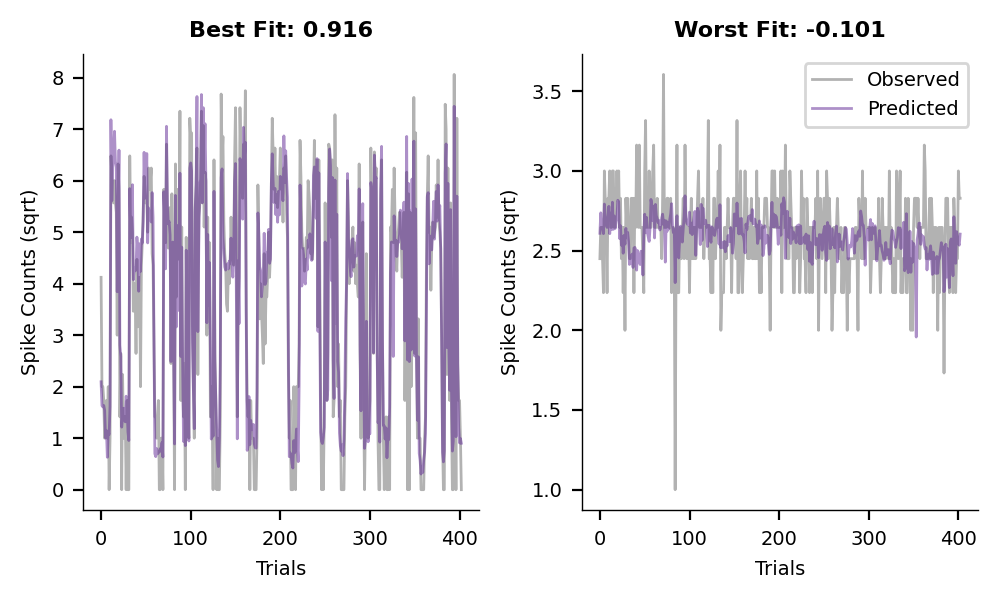

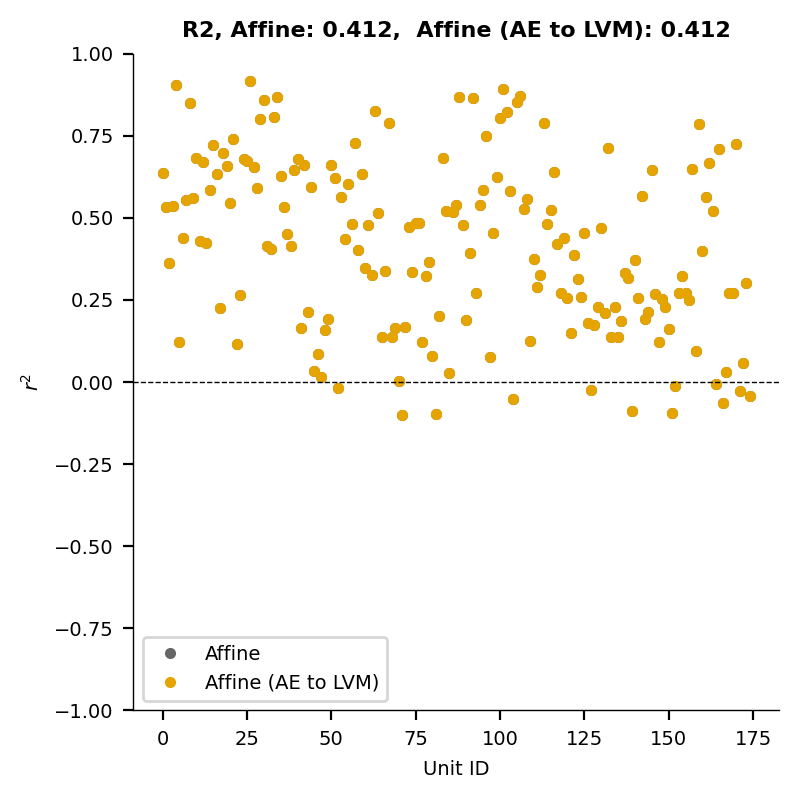

In [11]:
print("Step 2a: Eval")
res_affineae        = fitlvm_utils.eval_model(mod_ae_affine, data_gd, test_dl.dataset, do_plot=True, save=False)
res_affineaelvm     = fitlvm_utils.eval_model(mod_ae_affine_lvm, data_gd, test_dl.dataset, do_plot=True, save=False)
fitlvm_utils.plot_r2_comp([], res_affineae, res_affineaelvm, label_a="Affine", label_b="Affine (AE to LVM)", save=False)

In [12]:
# Step 5a: Fit gain only
print("Step 5a: Fit gain only")
mod_gain = fitlvm_utils.fit_gain(mod_ae_gain, mod_affine, train_dl, val_dl, cids, num_tv, num_units, data_gd, ntents=2, num_latents=3)

# Step 5b: Fit offset only
print("Step 5b: Fit offset only")
mod_offset = fitlvm_utils.fit_offset(train_dl, val_dl, mod_ae_affine, mod_affine, cids, num_tv, num_units, data_gd, num_latents=3)

Step 5a: Fit gain only
Fitting Gain Model...Initial: 0.2172
Initial: 0.2172
Fit latents: 0.2172, 0.3390
0) fit stim: 0.2172, 0.3393
0) fit latents: 0.3393, 0.3398
1) fit stim: 0.3398, 0.3392
breaking because tolerance was hit
Fit run 0.000,0.000: 0.3398, train loss = 0.5749
Done
Step 5b: Fit offset only
Fitting Offset Model...Initial: -0.5841
Initial: -0.5841
Fit latents: -0.5841, 0.3440
0) fit stim: -0.5841, 0.3453
0) fit latents: 0.3453, 0.3513
1) fit stim: 0.3513, 0.3492
breaking because tolerance was hit
Fit run 0.000,0.000: 0.3513, train loss = 0.5644
Done


In [17]:
# EVALUATION
print("Evaluating...")# EVALUATION
das_sess = fitlvm_utils.get_das(trial_data, regions, sample, train_inds, val_inds, test_inds, train_dl, test_dl, mod_baseline, mod_tv, mod_ae_offset, mod_ae_gain, mod_ae_affine_lvm, mod_affine, mod_gain, mod_offset, cids, data_gd, do_save=False, do_plot=True)

Evaluating...
as expected
as expected
Fitting CV PCA


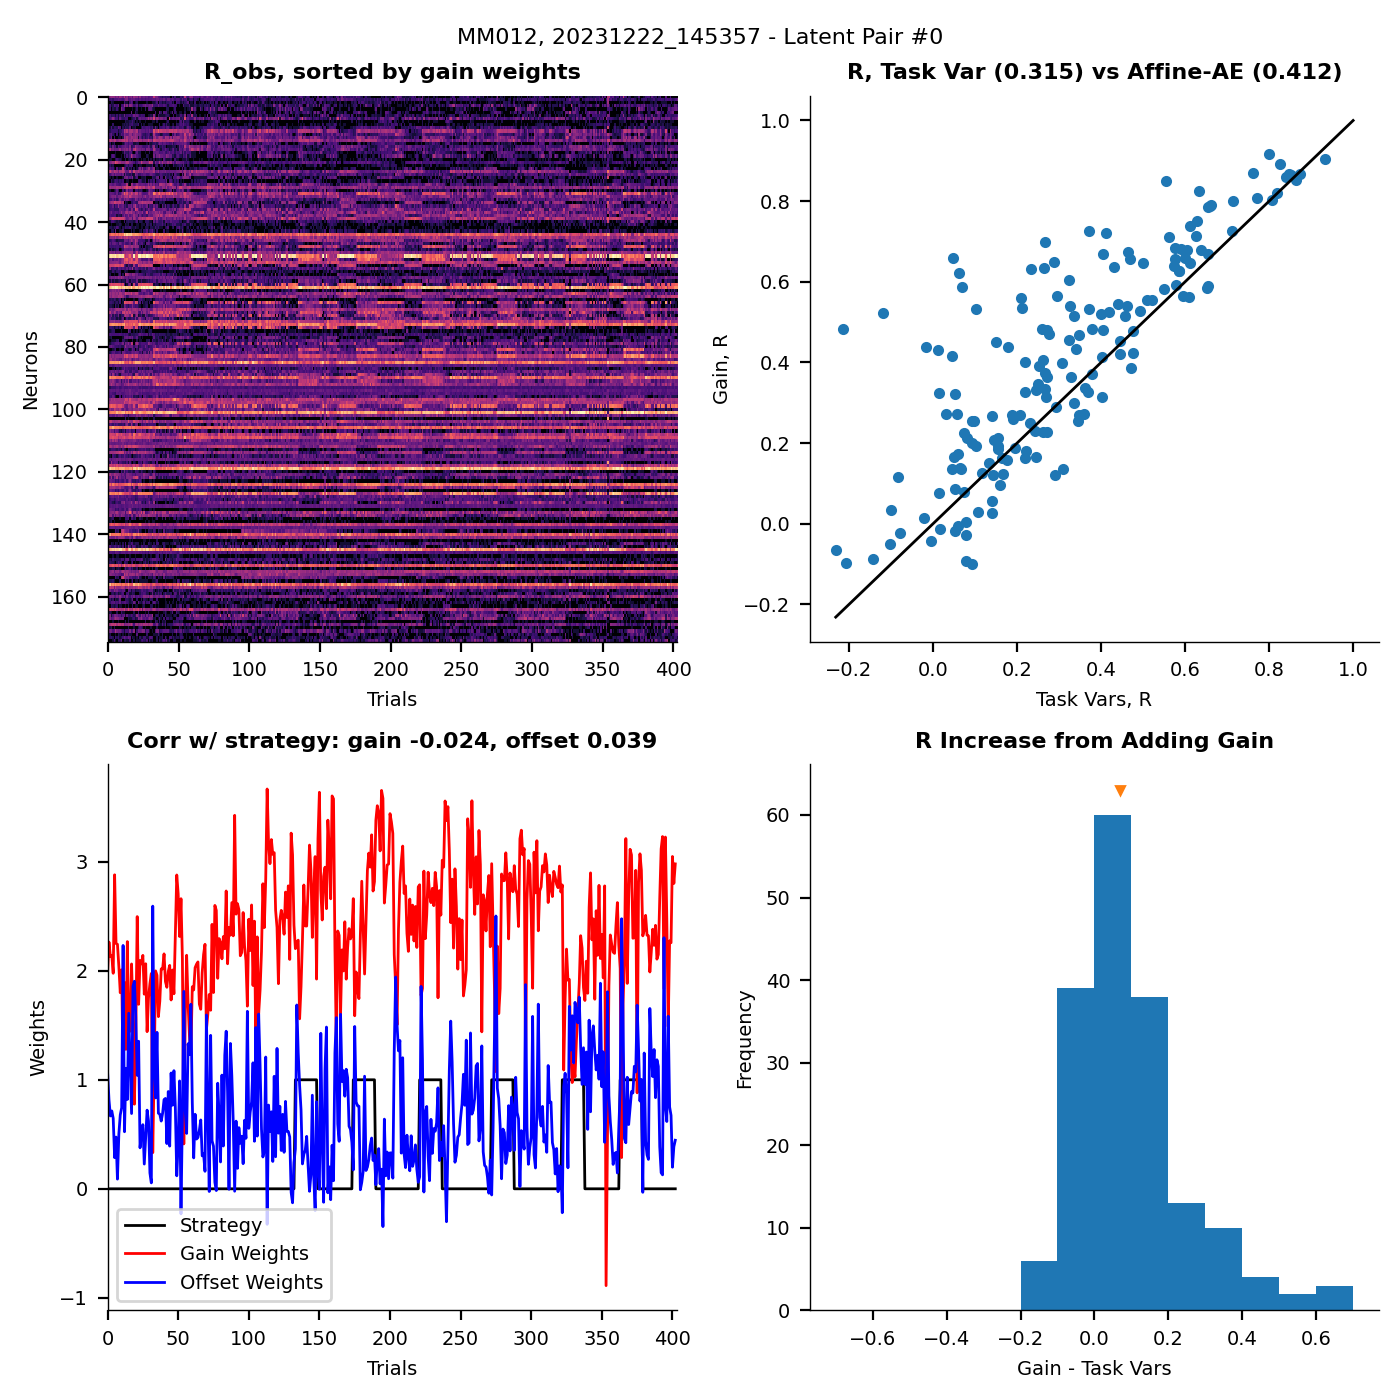

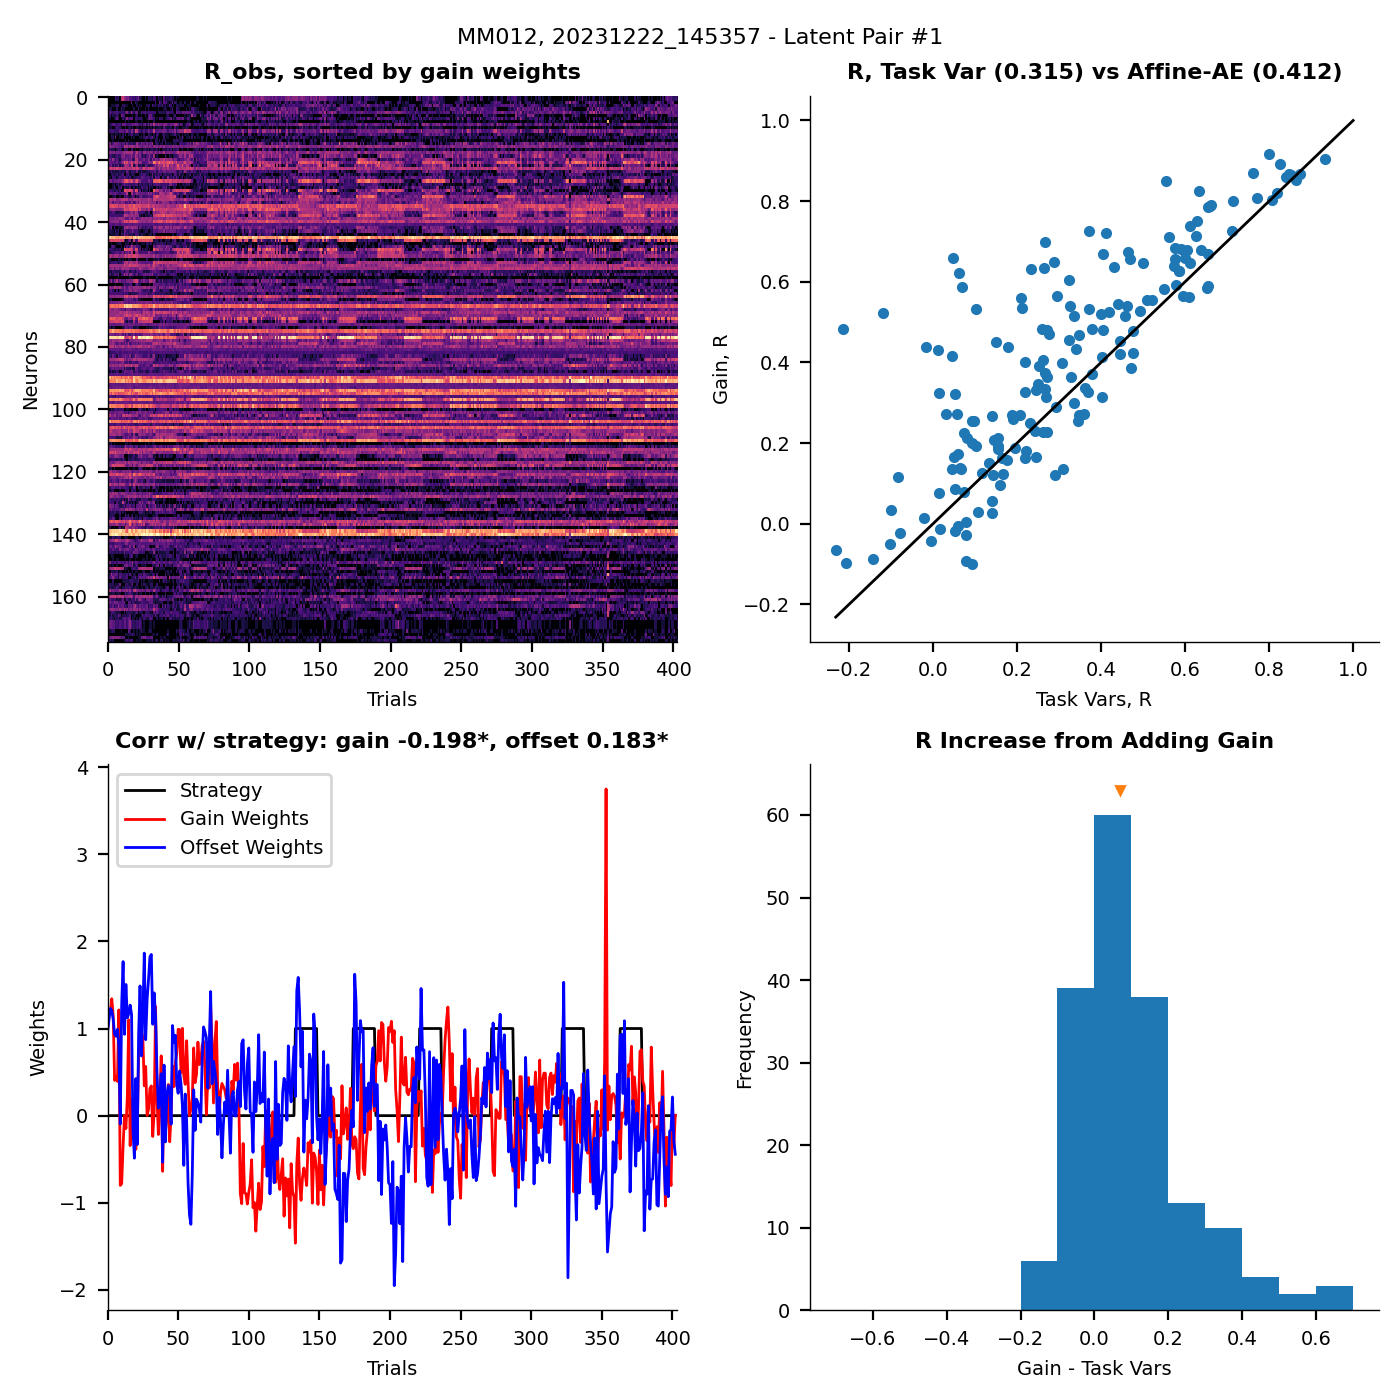

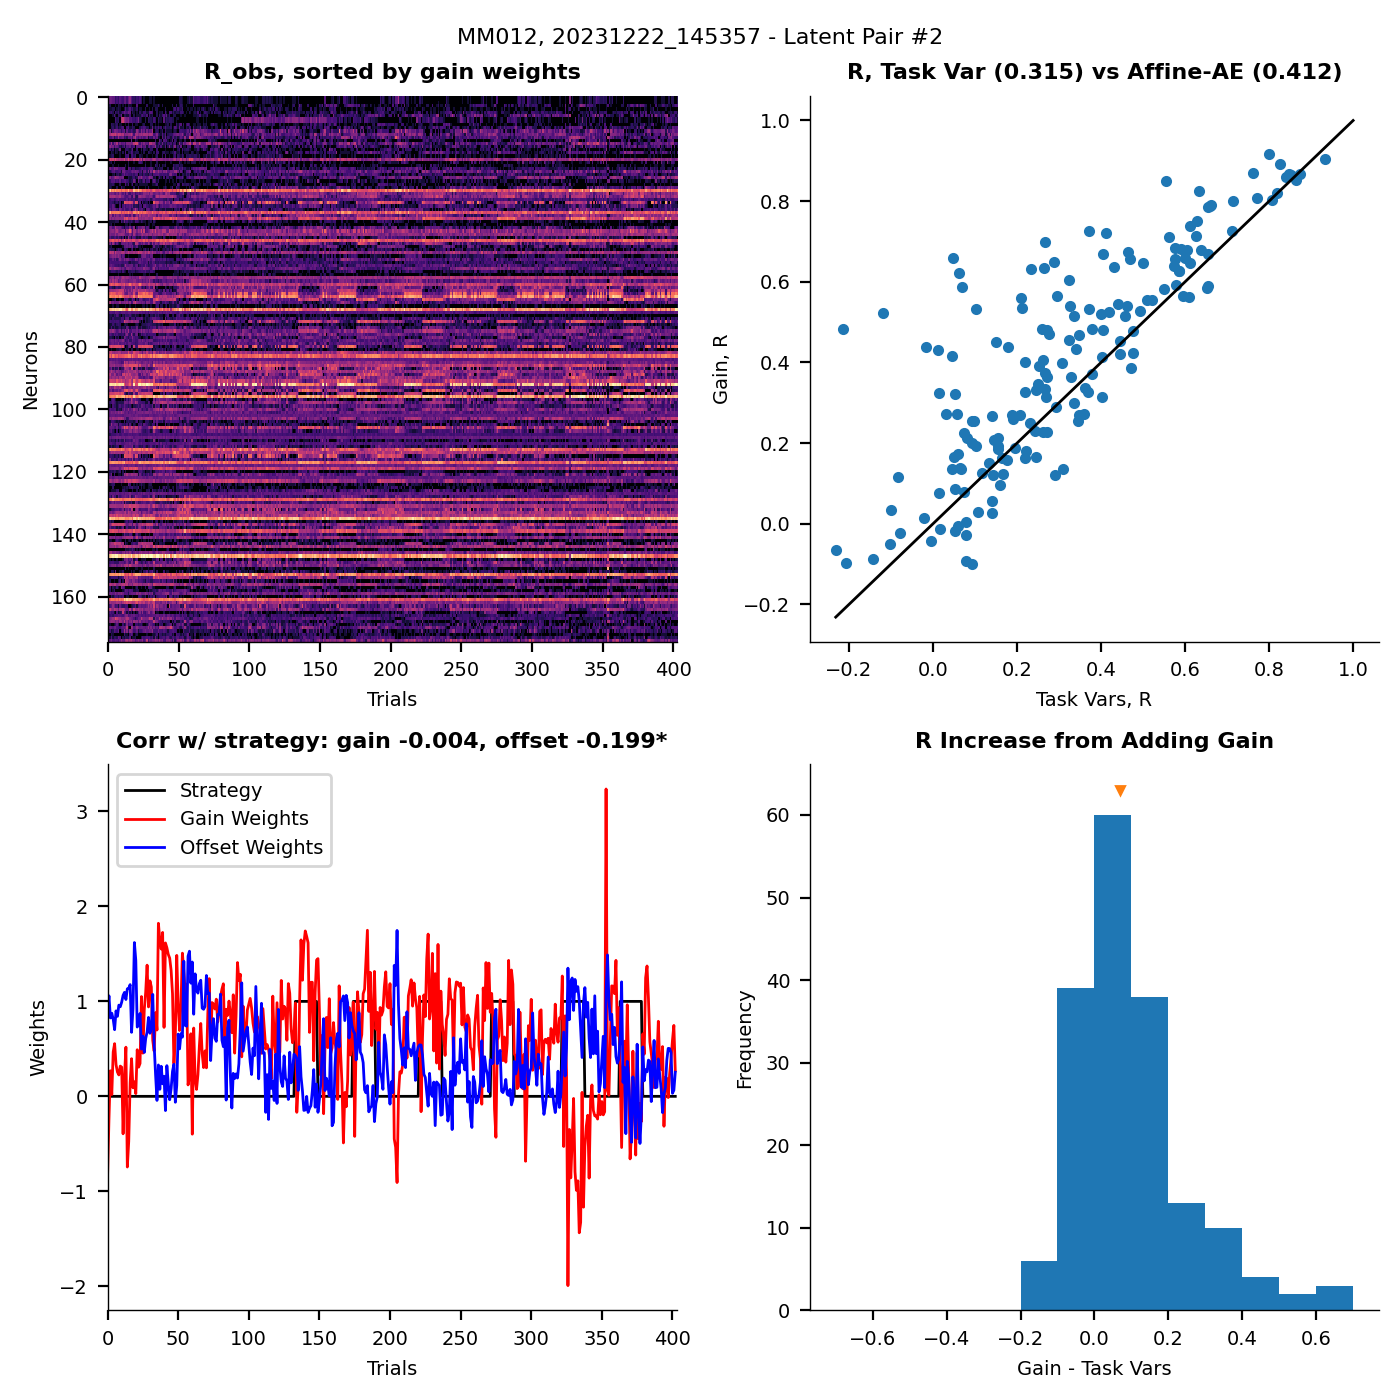

In [18]:
fitlvm_utils.plot_summary(das_sess, subj_idx=subj_idx, sess_idx=sess_idx)

In [ ]:
def foo(das, ax0, ax1, num_latents, is_mult=True, abort=True):
    markers = ['v', '^', 'x', '*']
    colors = ["#140C6A", "#7166E9", "#845910", "#F7E164"]

    cids = das['affine']['model'].cids
    coupling = das['affine']['model'].readout_gain.weight.data[:].T if is_mult else das['affine']['model'].readout_offset.weight.data[:].T

    regs = das['data']['regions']
    reg_keys = das['data']['reg_keys'][cids]
    
    
    if abort and all([all(coupling[np.where(reg_keys==i)[0],ax0] == coupling[np.where(reg_keys==i)[0],ax1]) for i in reg_keys]):
        print(f"Latent {ax0+1} and Latent {ax1+1} are equal, aborting")
        return

    fig, ax = plt.subplots(figsize=(3,3))

    for i, reg in enumerate(regs):
        idxs = np.where(reg_keys==i)[0]
        coupling_reg = coupling[idxs]
        ax.plot(coupling_reg[:,ax0], coupling_reg[:,ax1], markers[i], color=colors[i], label=reg)
        #ax.axhline(torch.mean(coupling_reg), color=colors[i], linewidth=0.3, linestyle='--')

    ax.axhline(0, color='k', linewidth=0.5, linestyle='--')
    ax.axvline(0, color='k', linewidth=0.5, linestyle='--')
    ax.set_xlabel(f'Latent {ax0+1}'); ax.set_ylabel(f"Latent {ax1+1}")
    fig.suptitle(f"Total # Latents: {num_latents}")
    
    ax.set_ylim([-0.5,0.5])
    ax.set_xlim([-0.5,0.5])

    ax.legend()
    fig.tight_layout()
    fig.show()
    
def bah(das, num_latents):
    for ax in range(num_latents):
        plt.plot(das['affineae']['model'].offset_mu.get_weights()[:,ax], alpha=0.5, label=f"Latent {ax+1}")
    plt.title(f"Total # Latents: {num_latents}")
    plt.legend()

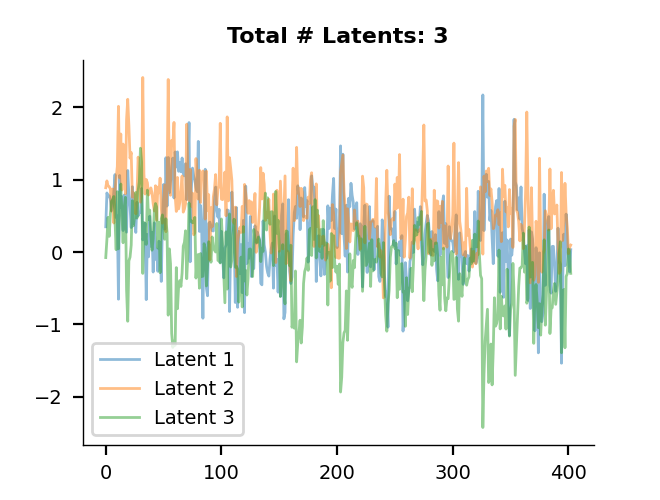

In [ ]:
bah(das_sess, num_latents=3)

Latent 1 and Latent 2 are equal, aborting


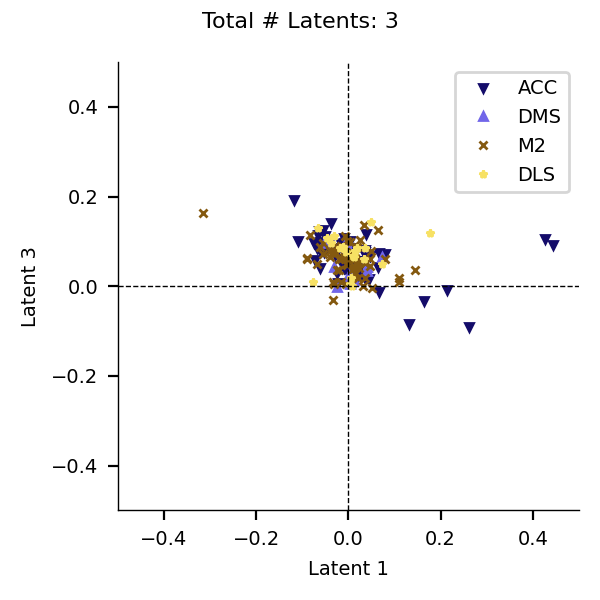

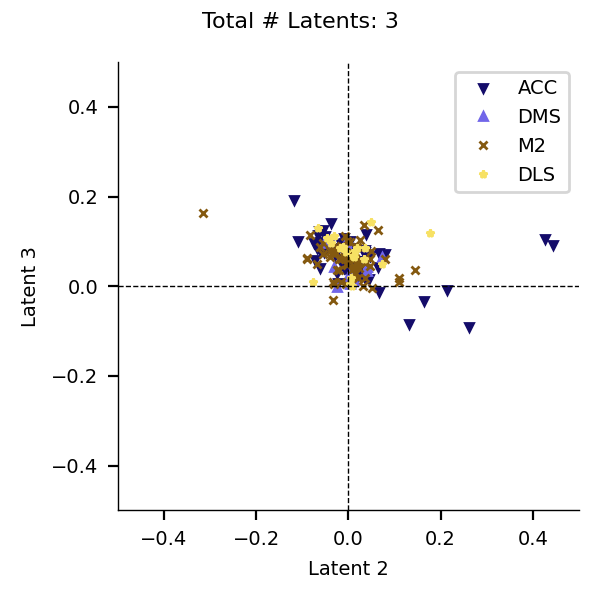

In [ ]:
for ax0 in range(3):
    for ax1 in range(3):
        if ax0 < ax1:
            foo(das_sess, ax0=ax0, ax1=ax1, num_latents=3)

## Grid Search

In [ ]:
# SERIAL
out = [fit_models.fit_sess(unit_spike_times_all[subj_idx][sess_idx], trial_data_all[subj_idx][sess_idx], session_data_all[subj_idx][sess_idx], regions_all[subj_idx][sess_idx], subj_idx, sess_idx, num_latents=latent_idx) for latent_idx in range(1,8+1)]
das = [out[latent_idx][0] for latent_idx in range(8)]

In [ ]:
# PARALLEL
def fit_sess_latents_gs(subj_idx, sess_idx):
    return Parallel(n_jobs=-1, backend='loky')(delayed(fit_models.fit_sess)(unit_spike_times_all[subj_idx][sess_idx], trial_data_all[subj_idx][sess_idx], session_data_all[subj_idx][sess_idx], regions_all[subj_idx][sess_idx], subj_idx, sess_idx, num_latents=num_latents) for num_latents in range(1,8+1))
out = fit_sess_latents_gs(subj_idx=subj_idx, sess_idx=sess_idx) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_03_latents.npy', das)

In [14]:
# PARALLEL
out = fit_sess_latents_gs(subj_idx=0, sess_idx=2) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_02_latents.npy', das)

In [15]:
# PARALLEL
out = fit_sess_latents_gs(subj_idx=0, sess_idx=1) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_01_latents.npy', das)

In [16]:
# PARALLEL
out = fit_sess_latents_gs(subj_idx=0, sess_idx=0) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_00_latents.npy', das)

In [17]:
# PARALLEL
out = fit_sess_latents_gs(subj_idx=0, sess_idx=4) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_04_latents.npy', das)

In [ ]:
from lib import eval_models

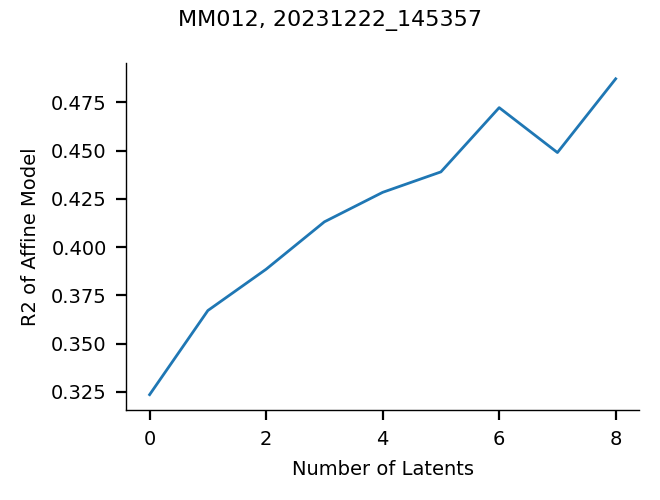

In [ ]:
eval_models.plot_r2_laatents(das, subj_idx=0, sess_idx=3, is_msess=False)

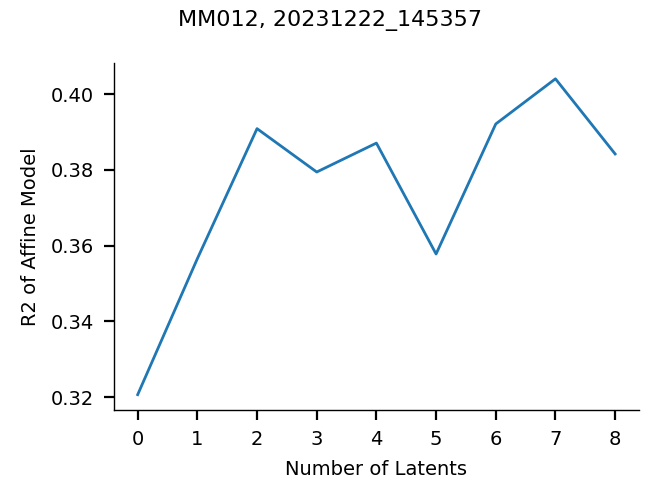

In [ ]:
eval_models.plot_r2_latents(das, subj_idx=0, sess_idx=3, is_msess=False, ae=False)

In [ ]:
def bah(das, num_latents, ae=True, mult=True):
    plt.figure()
    model = das['affineae'] if ae else das['affine']
    weights = model['model'].gain_mu.get_weights() if mult else model['model'].offset_mu.get_weights() 
    for ax in range(num_latents):
        plt.plot(weights[:,ax], alpha=0.5, label=f"Latent {ax+1}")
    plt.title(f"Total # Latents: {num_latents}")
    plt.legend()

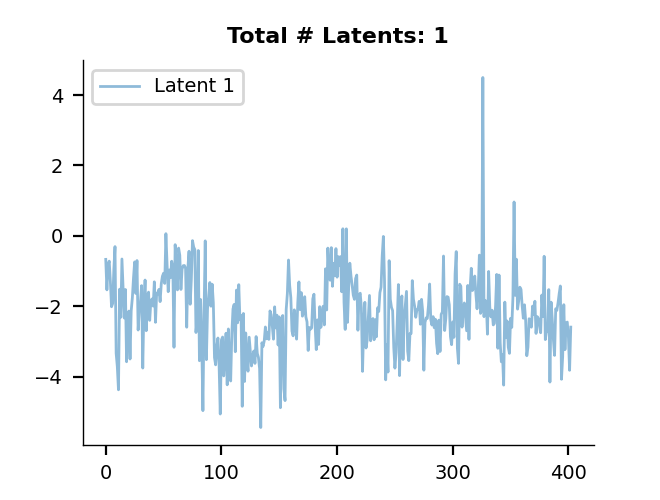

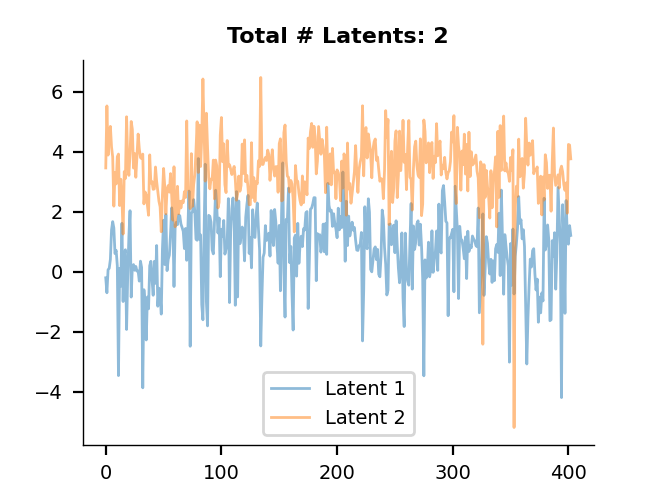

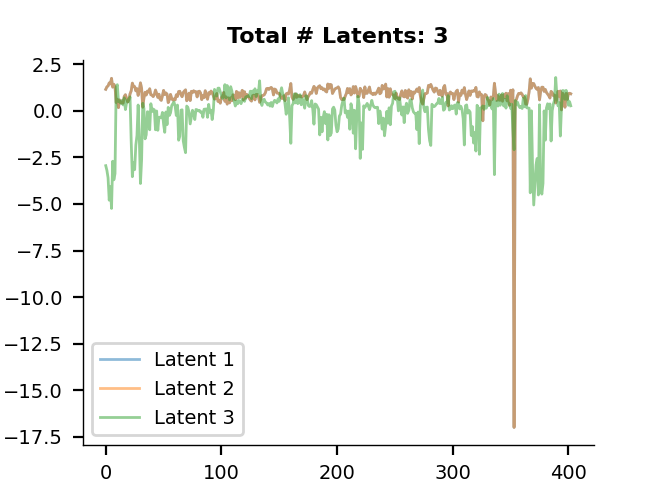

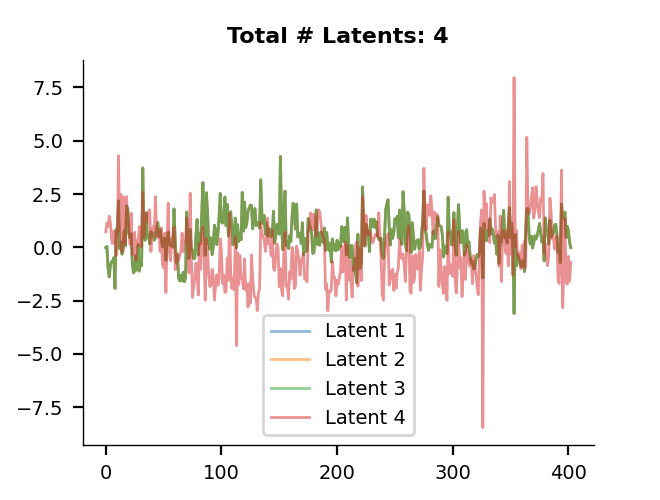

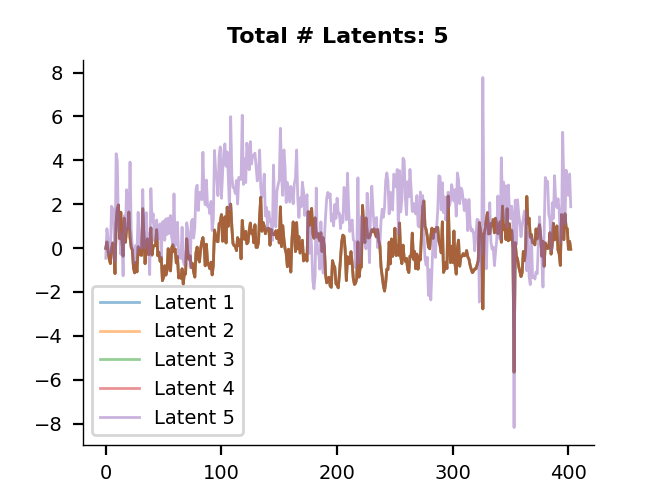

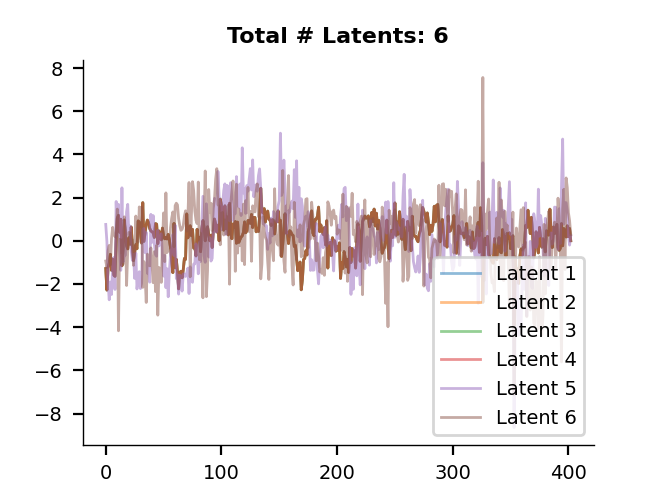

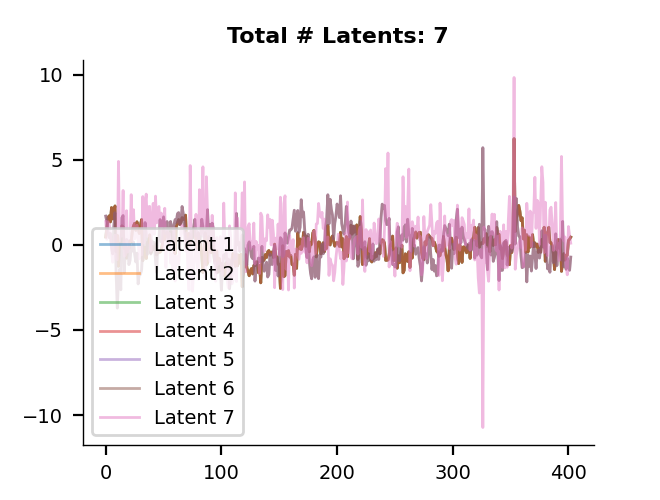

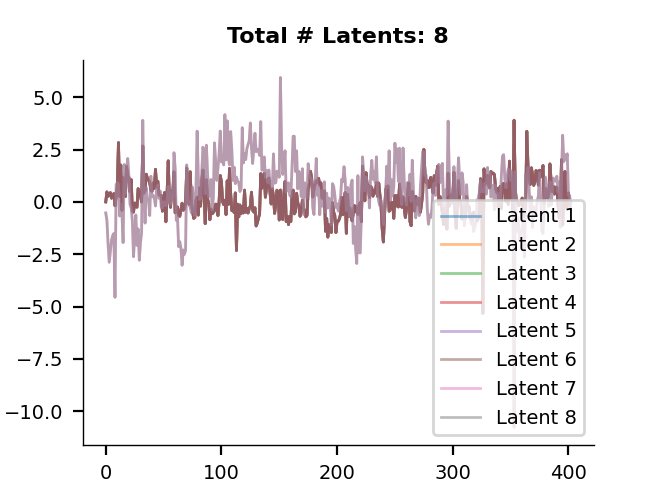

In [ ]:
for num_latents in range(1, 8+1): 
    bah(das[num_latents-1], num_latents=num_latents, ae=False)
     

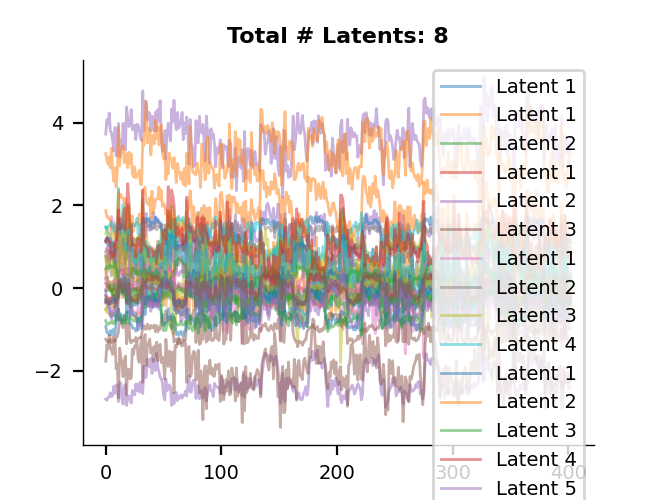